<a href="https://colab.research.google.com/github/RogMaverick18/ML-Lab-assignments/blob/main/ML_Lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lime
!pip install shap
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=348c421307e5040c55fff9c636bea80f69bbcee81e70bce81933668b6540957c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



A1: Correlation Heatmap


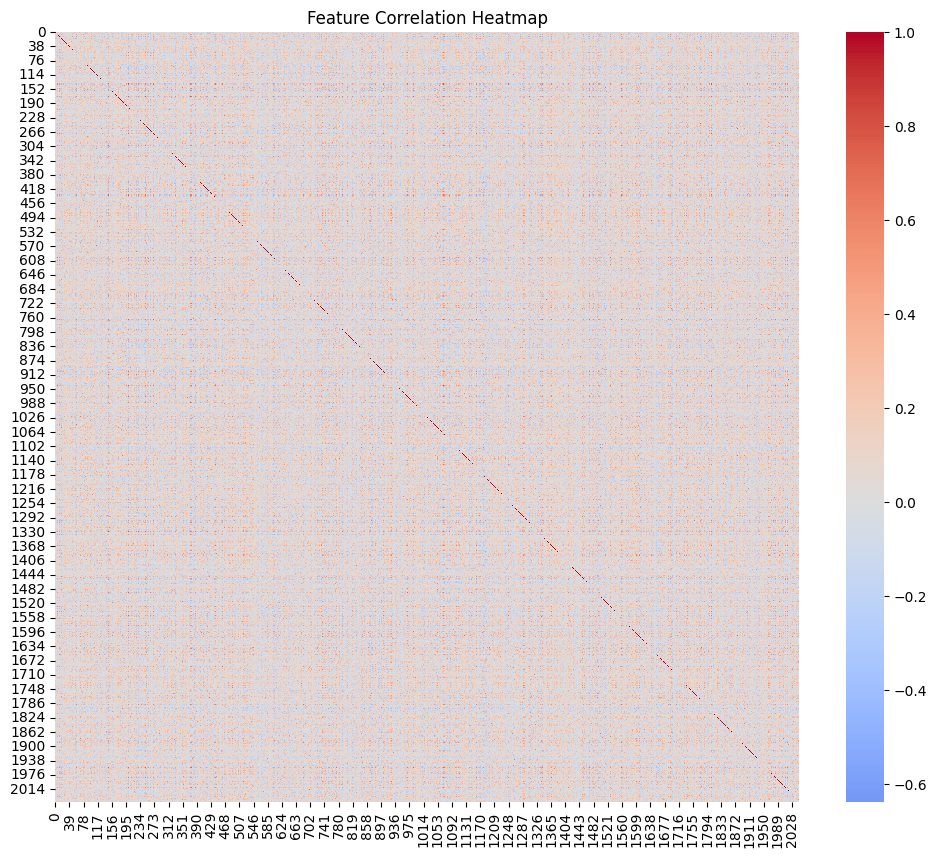


A2: PCA Classification (99% Variance)
Random Forest Accuracy (PCA 99%): 0.9200
SVM Accuracy (PCA 99%): 0.9900
Decision Tree Accuracy (PCA 99%): 0.8000
Naive Bayes Accuracy (PCA 99%): 0.7700
MLP Accuracy (PCA 99%): 0.8400

A3: PCA Classification (95% Variance)
Random Forest Accuracy (PCA 95%): 0.9100
SVM Accuracy (PCA 95%): 0.9900
Decision Tree Accuracy (PCA 95%): 0.8300
Naive Bayes Accuracy (PCA 95%): 0.8600
MLP Accuracy (PCA 95%): 0.8800

A4: Feature Selection using RF Importance (Top 20 Features)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Random Forest Accuracy (RF Feature Selection): 0.9000
SVM Accuracy (RF Feature Selection): 0.9000
Decision Tree Accuracy (RF Feature Selection): 0.7200
Naive Bayes Accuracy (RF Feature Selection): 0.8800
MLP Accuracy (RF Feature Selection): 0.9200

A5: LIME and SHAP Explanation


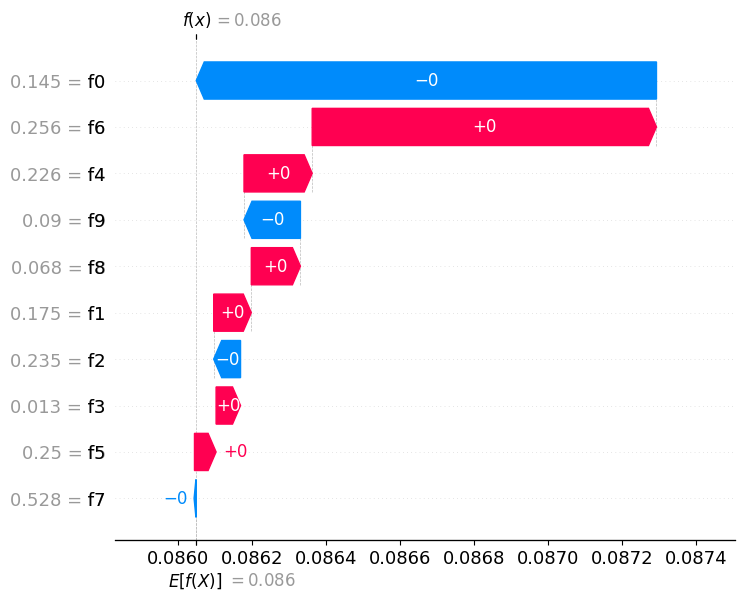

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap
import lime
import lime.lime_tabular
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

def load_features_from_pretrained_model(data_dir, sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    class ImageDataset(Dataset):
        def __init__(self, root_dir, transform):
            self.transform = transform
            self.image_paths, self.labels = [], []
            for label, class_name in enumerate(sorted(os.listdir(root_dir))):
                class_dir = os.path.join(root_dir, class_name)
                for img_file in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(label)

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image = Image.open(self.image_paths[idx]).convert("RGB")
            return self.transform(image), self.labels[idx]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval().to(device)

    dataset = ImageDataset(data_dir, transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            output = model(images).view(images.size(0), -1)
            features.append(output.cpu().numpy())
            labels.append(lbls.numpy())

    X = np.vstack(features)
    y = np.hstack(labels)
    if sample_size and sample_size < len(y):
        idx = np.random.choice(len(y), sample_size, replace=False)
        X, y = X[idx], y[idx]
    return X, y

# --- A1: Feature Correlation Heatmap ---
def plot_feature_correlation(X):
    corr_matrix = np.corrcoef(X.T)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title("Feature Correlation Heatmap")
    plt.show()

# --- A2 & A3: PCA Classification Experiment ---
def run_pca_and_classify(X, y, explained_var=0.99, classifiers=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=explained_var)
    X_pca = pca.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        results[name] = acc
    return results, pca.n_components_

# --- A4: Feature Selection using RandomForest Importance ---
def run_feature_selection_with_rf(X, y, classifiers, top_k=20):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_scaled, y)
    importances = rf.feature_importances_
    top_indices = np.argsort(importances)[-top_k:]
    X_selected = X_scaled[:, top_indices]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        results[name] = acc
    return results

# --- A5: LIME and SHAP Explainability ---
def explain_with_lime_shap(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    # SHAP: explain a single instance using model.predict to ensure scalar output
    explainer_shap = shap.TreeExplainer(model)
    shap_values = explainer_shap.shap_values(X_test[:1])
    # Select the SHAP values for the first class (index 0) and the first instance (index 0)
    shap.plots.waterfall(shap.Explanation(values=shap_values[0][0], base_values=explainer_shap.expected_value[0],
                                           data=X_test[0], feature_names=[f"f{i}" for i in range(X.shape[1])]))

    # LIME: Local explanation for a single prediction
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=[f"f{i}" for i in range(X.shape[1])],
        class_names=["class 0", "class 1"],
        discretize_continuous=True
    )
    explanation = explainer_lime.explain_instance(X_test[0], model.predict_proba, num_features=10)
    explanation.show_in_notebook()

# --- MAIN PROGRAM ---
def main():
    X, y = load_features_from_pretrained_model("/content/drive/MyDrive/Colab Notebooks/flowers/train", sample_size=500)

    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(kernel="linear", probability=True),
        "Decision Tree": DecisionTreeClassifier(),
        "Naive Bayes": GaussianNB(),
        "MLP": MLPClassifier(max_iter=300)
    }

    print("\nA1: Correlation Heatmap")
    plot_feature_correlation(X)

    print("\nA2: PCA Classification (99% Variance)")
    pca99_results, n_comp_99 = run_pca_and_classify(X, y, 0.99, classifiers)
    for name, acc in pca99_results.items():
        print(f"{name} Accuracy (PCA 99%): {acc:.4f}")

    print("\nA3: PCA Classification (95% Variance)")
    pca95_results, n_comp_95 = run_pca_and_classify(X, y, 0.95, classifiers)
    for name, acc in pca95_results.items():
        print(f"{name} Accuracy (PCA 95%): {acc:.4f}")

    print("\nA4: Feature Selection using RF Importance (Top 20 Features)")
    fs_results = run_feature_selection_with_rf(X, y, classifiers, top_k=20)
    for name, acc in fs_results.items():
        print(f"{name} Accuracy (RF Feature Selection): {acc:.4f}")

    print("\nA5: LIME and SHAP Explanation")
    explain_with_lime_shap(X, y)

main()